In [1]:
# Imports
import warnings; warnings.simplefilter("ignore")

from datetime import datetime, timedelta

from Database import db
 
import numpy as np
import pickle
import os
import re

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from keras.optimizers import RMSprop, Adam
from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K
from keras.utils import plot_model

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Using TensorFlow backend.


In [2]:
# Options

stocks      = ['AMD', 'INTC', 'AAPL', 'AMZN', 'MSFT', 'GOOG']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha', 'fool', 'wsj', 'thestreet']

model_type  = 'multiheadlineclf'

doc2vec_options = dict(
    size=300, 
    window=10, 
    min_count=5, 
    workers=10,
    alpha=0.025, 
    min_alpha=0.025, 
    max_vocab_size=13000,
    dm=1
)

keras_options = dict(
    epochs=200, 
    batch_size=32,
    verbose=0
)

tick_window = 12
doc_query_days = 10
combined_emb_size = 5 + doc2vec_options['size']

test_cutoff = datetime(2018, 4, 12) # TODO use this for train/test split

In [3]:

def add_time(date, days):
    
    return (date + timedelta(days=days)).strftime('%Y-%m-%d')

def clean(sentence):

    sentence = sentence.lower()
    sentence = sentence.replace('-', ' ').replace('_', ' ').replace('&', ' ')
    sentence = ''.join(char for char in sentence if char in "abcdefghijklmnopqrstuvwxyz.!? ")
    sentence = re.sub('\s+', ' ', sentence).strip()
    
    return sentence

def clean2(sentence): # Clean already cleaned headline (aka return this)
    return sentence

def make_doc_embeddings(query_range=(None, '1776-07-04', '3000-01-01'), use_extra_dates=True, vec_model=None):
    """
    Create document embeddings from headlines
    """
    if not vec_model: print('Creating doc embeddings...')

    docs, labels = [], []
    
    class LabeledLineSentence:
        
        def __init__(self, docs, labels):
            self.docs = docs
            self.labels = labels
            
        def __iter__(self):
            for idx, doc in enumerate(self.docs):
                yield TaggedDocument(doc.split(), [self.labels[idx]]) # clean doc
    
    with db() as (conn, cur):
        
        q_stock, q_start, q_end = query_range
        
        for stock in stocks:
            
            ## Headline For Every Date ##
            
            if q_stock and q_stock != stock:
                continue
            
            cur.execute("SELECT DISTINCT date FROM headlines WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC", [stock, q_start, q_end])
            dates = [date[0] for date in cur.fetchall()]
            
            if use_extra_dates: # True headline days not enough so we create additional querys
                new_dates = []
                for date in dates: 
                    d = datetime.strptime(date, '%Y-%m-%d')
                    new_dates.append(add_time(d, -1))
                    new_dates.append(add_time(d, +1))
                dates.extend(new_dates)
                
            if not vec_model: # Show loading bar only for training data
                date_iter = tqdm_notebook(dates, desc=stock)
            else:
                date_iter = iter(dates)
            
            for date in date_iter:
                
                ## Collect Headlines ##
                
                event_date = datetime.strptime(date, '%Y-%m-%d')
                
                cur.execute("SELECT date, source, rawcontent FROM headlines WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC", 
                            [stock, add_time(event_date, -doc_query_days), date])
                headlines = [(date, source, clean(content), (event_date - datetime.strptime(date, '%Y-%m-%d')).days) 
                                 for (date, source, content) in cur.fetchall() if content]
                
                if len(headlines) == 0:
                    continue
                
                ## Create training example ##
                    
                contents = [headline[2] for headline in headlines]

                doc = " **NEXT** ".join(contents)
                
                docs.append(doc)
                labels.append(stock + " " + date)
                
    vectors = {stock: {} for stock in stocks}
            
    doc_iter = LabeledLineSentence(docs, labels)
    
    if not vec_model:
        
        vec_model = Doc2Vec(documents=doc_iter, **doc2vec_options)
        #     vec_model = Doc2Vec(**doc2vec_options)
        #     vec_model.build_vocab(doc_iter)

        #     for epoch in range(100):
        #         vec_model.train(doc_iter, **doc2vec_options)
        #         vec_model.alpha -= 0.002
        #         vec_model.min_alpha = vec_model.alpha
        
        for label in labels:
        
            stock, date = label.split(" ")

            vectors[stock][date] = vec_model.docvecs[label]
        
    else:
        
        for tag_doc in doc_iter:
            
            vec = vec_model.infer_vector(tag_doc.words, 
                                         alpha=doc2vec_options['alpha'], 
                                         min_alpha=doc2vec_options['min_alpha'], 
                                         steps=1000)
            
            stock, date = tag_doc.tags[0].split(" ")
            
            vectors[stock][date] = vec
            
    return vec_model, vectors, (docs, labels)

def make_tick_data(query_range=(None, '1776-07-04', '3000-01-01'), train=True):
    """
    Process historic tick data (high/low/close/etc..) into training examples
    """
    if train: print('Creating tick data...')
    
    tick_vecs = {stock: {} for stock in stocks}
    effect_vecs = {stock: {} for stock in stocks}
    
    with db() as (conn, cur):
        
        q_stock, q_start, q_end = query_range
        
        for stock in stocks:
            
            if q_stock and q_stock != stock:
                continue
            
            cur.execute("SELECT DISTINCT date FROM headlines WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1", [stock, q_start, q_end])
            start_date = cur.fetchall()[0][0]
            
            cur.execute("SELECT DISTINCT date FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC", [stock, start_date, q_end])
            dates = [date[0] for date in cur.fetchall()]
            
            for date in dates:
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline

                ## Find corresponding tick data ## 

                cur.execute("""SELECT open, high, low, adjclose, volume FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC LIMIT 52""", 
                            [stock, 
                             add_time(event_date, -80), 
                             add_time(event_date, 0)])

                before_headline_ticks = cur.fetchall()

                if len(before_headline_ticks) < tick_window:
                    continue
                    
                if train:

                    cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
                                [stock, 
                                add_time(event_date, 1), 
                                add_time(event_date, 4)])

                    after_headline_ticks = cur.fetchall()

                    if len(after_headline_ticks) == 0 and train:
                        continue
                    
                ## Create ##

                window_ticks = np.array(list(reversed(before_headline_ticks[:tick_window]))) # Flip so in chron. order
                fifty_ticks = np.array(before_headline_ticks) # Use last 50 ticks to normalize

                previous_tick = before_headline_ticks[0][3]
                
                if train:
                    result_tick = after_headline_ticks[0][0]

                if previous_tick:

                    window_ticks -= np.mean(fifty_ticks, axis=0)
                    window_ticks /= np.std(fifty_ticks, axis=0)
                    
                    tick_vecs[stock][date] = window_ticks
                    
                    if train:
                    
                        if result_tick > previous_tick:
                            effect = [1., 0.]
                        else:
                            effect = [0., 1.]

                        effect_vecs[stock][date] = effect
                    
    return tick_vecs, effect_vecs


In [4]:

def merge_data(doc_vecs, tick_vecs, effect_vecs=None):
    """
    Pairs document and tick vectors (both timeseries) to an effect vector (up/down)
    """
    if effect_vecs: print('Creating X, Y...')
    
    X, Y, test_indices = [], [], []
    
    for stock in stocks:
        
        for date, tick_vec in tick_vecs[stock].items():
            
            x = []
            
            if effect_vecs:
                y = effect_vecs[stock][date]
            
            event_date = datetime.strptime(date, '%Y-%m-%d')
            
            window_dates = [add_time(event_date, -i) for i in range(tick_window)]
            
            for i in range(tick_window):
                
                if window_dates[i] not in doc_vecs[stock]:
                    break
                    
                x_i = np.concatenate([tick_vec[i], doc_vecs[stock][window_dates[i]]]) # Combine tick data and doc data
                
                x.append(x_i)
                
            if len(x) == tick_window:
                
                X.append(x)
                
                if effect_vecs:
                    
                    Y.append(y)
                
                    if event_date > test_cutoff: # Label as test data
                        test_indices.append(len(X) - 1)
        
    return np.array(X), np.array(Y), np.array(test_indices)


In [5]:

def split_data(X, Y, test_indices):
    """
    Splits X/Y to Train/Test
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    train_indices = np.setdiff1d(indices, test_indices, assume_unique=True)
    
    trainX,  testX  = X[train_indices],  X[test_indices]
    trainY,  testY  = Y[train_indices],  Y[test_indices]
    
    return trainX, trainY, testX, testY


In [6]:

def correct_sign_acc(y_true, y_pred): # Currently not used
    """
    Accuracy of Being Positive or Negative
    """
    diff = K.equal(y_true > 0, y_pred > 0)
    
    return K.mean(diff, axis=-1)

def get_model():
    
    model_input = Input(shape=(tick_window, combined_emb_size), name="Input")
    
    rnn = LSTM(500, return_sequences=False)(model_input)
    rnn = Dropout(0.3)(rnn)
    
    dense = Dense(500)(rnn)
    dense = Activation('selu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(500)(dense)
    dense = Activation('selu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(2)(dense)
    pred_output = Activation('softmax')(dense)
    
    model = Model(inputs=model_input, outputs=pred_output)
    
    model.compile(optimizer=Adam(), loss='mse', metrics=['acc'])
    
    return model


In [7]:
# Load Data

if __name__ == "__main__":
    
    vec_model, doc_vecs, doc_data = make_doc_embeddings() #vec_model.docvecs.most_similar("INTC 2016-04-20")
    
    tick_vecs, effect_vecs = make_tick_data()
    
    X, Y, test_indices = merge_data(doc_vecs, tick_vecs, effect_vecs)
    
    trainX, trainY, testX, testY = split_data(X, Y, test_indices)
    
    print(trainX.shape, testY.shape)


Creating doc embeddings...


HBox(children=(IntProgress(value=0, description='AMD', max=5292), HTML(value='')))

HBox(children=(IntProgress(value=0, description='INTC', max=6408), HTML(value='')))

HBox(children=(IntProgress(value=0, description='AAPL', max=5916), HTML(value='')))

HBox(children=(IntProgress(value=0, description='AMZN', max=6279), HTML(value='')))

HBox(children=(IntProgress(value=0, description='MSFT', max=6066), HTML(value='')))

HBox(children=(IntProgress(value=0, description='GOOG', max=5103), HTML(value='')))


Creating tick data...
Creating X, Y...
(7264, 12, 305) (96, 2)


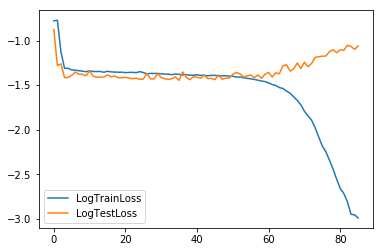

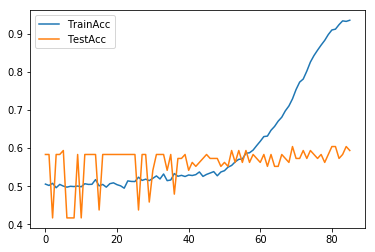

In [8]:
# TRAIN MODEL

if __name__ == "__main__":  

    ## Create Model ##
    
    model = get_model()
    
    monitor_mode = 'acc'
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y,%m,%d-%H,%M,%S,tick," + model_type)))
    e_stopping = EarlyStopping(monitor='val_loss', patience=50)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'), 
                                 monitor=monitor_mode,
                                 verbose=0,
                                 save_best_only=True)
    
    vec_model.save(os.path.join('..', 'models', 'doc2vec-' + model_type + '.doc2vec'))
    
    plot_model(model, to_file='model.png', show_shapes=True)
    
    ## Train ##
    
    history = model.fit(trainX,
                        trainY,
                        validation_data=(testX, testY),
                        callbacks=[e_stopping, tensorboard, checkpoint],
                        **keras_options)
    
    ## Display Train History ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history[monitor_mode])
    plt.plot(history.history['val_' + monitor_mode])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()


In [9]:
# AoC

if __name__ == "__main__":

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix
    
    try:
        
        actualY = testY
        predictY = model.predict(testX)
        
        print("ROC", roc_auc_score(actualY, predictY))
        
        print(confusion_matrix(testY[:, 0] > .7, predictY[:, 0] > .7))
        
    except NameError:
        
        print("Test Data and Model Required!")
    

ROC 0.5808035714285715
[[18 22]
 [20 36]]


In [8]:
# Predict (TEST)

def predict(stock, model=None, vec_model=None, current_date=None, predict_date=None):
    
    ## Check Args ##
    
    if not model or not vec_model:
        
        vec_model = Doc2Vec.load(os.path.join('..', 'models', 'doc2vec-' + model_type + '.doc2vec'))
    
        model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))
        
    if not current_date:
        current_date = datetime.today()
        
    if not predict_date:
        predict_date = current_date + timedelta(days=1)
        
    ## Predict ##
    
    query_range = stock, add_time(current_date, -tick_window-1), add_time(current_date, 0)
    
    vec_model, doc_vecs, _ = make_doc_embeddings(query_range=query_range, vec_model=vec_model)
    
    tick_vecs, _ = make_tick_data(query_range=query_range, train=False)
    
    X, _, _ = merge_data(doc_vecs, tick_vecs, None)
    
    pred = model.predict(X)
        
    return pred
    

In [10]:
# [TEST] Spot Testing

if __name__ == "__main__":
    
    ## **This Test May Overlap w/Train Data** ##
    
    ## Options ##
    
    stock = 'AMD'
    current_date = '2018-05-07'
    predict_date = '2018-05-08'
    
    ## Run ##
    
    predictions = predict(stock, 
                          current_date=datetime.strptime(current_date, '%Y-%m-%d'), 
                          predict_date=datetime.strptime(predict_date, '%Y-%m-%d'))
    
    ## Find Actual Value ##
     
    with db() as (conn, cur):
    
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
                        [stock, 
                        add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 0), 
                        add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 6)])

        after_headline_ticks = cur.fetchall()
        try:
            actual_result = after_headline_ticks[0][0]
        except:
            actual_result = -1
            
    ## Display ##
            
    parse = lambda num: str(round(num, 2))
    
    print(np.argmin(pred, axis=1))
    print(parse(np.mean(pred[:, 0])))
    
    print("Actual Price: " + parse(actual_result))
            

[0]
0.06333375
Actual Price: 53.33
